## Plot and analyze taxonomic classification
Code to plot and analyze the taxonomic classification made by Qiime2. The input data must be in the format of:
- Rows: Each row is one sequence, with an ID column
- Columns: Each column is the taxonomic classification at one level. Might have one level for the classification confidence as well. 

In [5]:
# TO BE SPECIFIED
# True taxonomy and conversion table with species names that might have synonyms
taxonomy_key = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/01_Collect_sequences/02_Sequences/All_downloaded_5dec/Taxonomy_species_genus_corrected.csv'
conversion_table = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Species_conversion.txt'

# The input classifications
# 1) Unsimulated reads
input_V3V4_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/01_Unsimulated_reads/V3V4/Full_length_classifier/Greengenes2/V3V4_gg_long_class_fixed.csv'
input_V3V4_gg_short_class = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/01_Unsimulated_reads/V3V4/Short_classifier/V3V4_gg_short_class_fixed.csv'
input_V1V9_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/01_Unsimulated_reads/V1V9/Greengenes2/V1V9_gg_fixed.csv'

# 2) Simulated reads
input_illumina_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/02_Simulated_reads/Illumina/Greengenes2/illumina_gg_names_fixed.csv'
input_pacbio_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/02_Simulated_reads/Pacbio/Greengenes2/pacbio_gg_names_fixed.csv'

### 1. Set up the program

In [6]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

#### 1.1 Define the plot colors and read the taxonomy key

In [7]:
# Define the color map for plotting
taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

n = len(taxonomic_levels)

# Create the color maps
# For plotting without and with the taxonomic key
cmap_nokey = plt.cm.get_cmap('Blues', n+1)
cmap_key = plt.cm.get_cmap('Greens', n+1)

color_levels_nokey = {}
color_levels_key = {}
for i in range(1, n+1):
    color_levels_nokey[taxonomic_levels[i-1]] = cmap_nokey(i)
    color_levels_key[taxonomic_levels[i-1]] = cmap_key(i)

color_levels_nokey['Unassigned'] = 'orange'
color_levels_key['Unassigned'] = 'orange'
color_levels_key['Wrong kingdom'] = 'crimson'

In [8]:
# Read the data
# The correct taxonomy and the conversion table
taxonomy = pd.read_csv(taxonomy_key, index_col='Feature ID')
conversion = pd.read_csv(conversion_table)

# Create a conversion dictionary for species with multiple names
conversion.columns = ['Species', 'Synonyms']
conversion_dict = {}
for ID in conversion.index:
    if conversion.loc[ID, 'Species'] not in conversion_dict.keys():
        conversion_dict[conversion.loc[ID, 'Species']] = [conversion.loc[ID, 'Synonyms']]
    else:
        conversion_dict[conversion.loc[ID, 'Species']].append(conversion.loc[ID, 'Synonyms'])

#### 1.2 Define the necessary functions

##### To plot without taxonomy key

In [9]:
def find_class_levels_nokey(dataframe):
    '''Takes a dataframe and calculates the number of sequences that have been classified (not NA) to the different
    taxonomical levels regardless of if the classification is correct or not.
    Input: Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    Output: A dataframe containing:
    - N° sequences that have each taxonomic level as their highest (1*C)'''

    # Count the number of unassigned sequences
    if 'Unassigned' in dataframe['Kingdom'].tolist():
        ua = dataframe.value_counts('Kingdom')['Unassigned']
    else:
        ua = 0

    # Count number of not-null cells at each taxonomic level (column)
    # Substract the number of unassigned sequences from the total number at kingdom level
    class_all_levels = dataframe.notnull().sum()
    class_all_levels['Kingdom'] = class_all_levels['Kingdom'] - ua
    class_highest_level = class_all_levels.copy(deep=True)

    # Loop through the levels and calculate the number of sequences with each level as their highest classification
    for level in range(len(class_all_levels)-1):
        class_highest_level[level] -= class_all_levels[level+1]
    class_all_levels = class_all_levels.to_frame()
    class_all_levels = pd.concat([class_all_levels, pd.DataFrame([ua], index=['Unassigned'], columns=class_all_levels.columns)])

    class_highest_level = pd.concat([class_highest_level, pd.DataFrame([ua], index=['Unassigned'], columns=class_all_levels.columns)])
    class_highest_level = class_highest_level.transpose()

    return class_highest_level

In [10]:
def highest_classification(samples, names):
    '''Calculate statistics from classifications, without a taxonomy key.
    Input:
    - Samples: List of classifications
    - Names: List of the samples' names
    Output: Two dataframes with
    - The number of sequences which has each level as their highest taxonomic classification
    - The ratio of sequences which has each level as their highest taxonomic classification'''
    
    # Find the number of sequences
    all_highest_class = pd.concat([find_class_levels_nokey(sample) for sample in samples])
    all_highest_class.index = names

    all_highest_class_ratio = all_highest_class.copy(deep=True)

    # Calculate the ratios
    for name in range(len(names)):
        all_highest_class_ratio.iloc[name,:] /= all_highest_class.iloc[name,:].sum()
    all_highest_class_ratio.columns = pd.CategoricalIndex(all_highest_class_ratio.columns.values, ordered=True, categories=['Unassigned'] + [level for level in samples[0].columns])
    all_highest_class_ratio = all_highest_class_ratio.sort_index(axis=1)

    return all_highest_class, all_highest_class_ratio

##### To plot with taxonomy key

In [11]:
# Find misclassified sequences
def find_misclassified(dataframe, correct_classification, conversion_table):
    '''Takes a dataframe and calculates the number of sequences that have been classified correctly (not NA)
    to the different taxonomical levels by comparing each sequence to its corresponding sequence in the correct
    classification. For incorrectly classified sequences, the program can also look in the conversion table to
    see if it is due to heteronyms, and then label is at correct.
    Input: 
    - Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    - Correct classification: The expected taxonomy, in the same format as the input dataframe
    - Conversion table: A dictionary with possible synonyms in the classification that still should be
    considered correct
    Output: A dataframe with the number of correctly classified sequences at each taxonomic level'''

    # Create a copy to not mess with the original datafiles
    dataframe_genus_species = dataframe.applymap(lambda x: x.strip() if type(x)==str else x)
    taxonomy_genus_species = correct_classification.applymap(lambda x: x.strip() if type(x)==str else x)
    taxonomy_genus_species['Species'].fillna('', inplace=True)
    
    # Look through all sequences
    for ID in dataframe.index:
        # If the whole species name (genus + species) is the same as the taxonomy, the classification is correct at species level
        if dataframe_genus_species.loc[ID,'Species'] == taxonomy_genus_species.loc[ID,'Species']:
            if dataframe_genus_species.loc[ID,'Genus'] == taxonomy_genus_species.loc[ID,'Genus']:
                correct = 'Species'
        
        # If not correct at species level, loop over all levels to find one at which the taxonomy is correct
        # There there is no level that is correct, it is probably "unassigned"
        # Check if the classification is wrong at the kingdom level
        else:
            for level in reversed(dataframe.columns[:-1]):
                if dataframe_genus_species.loc[ID,level] == taxonomy_genus_species.loc[ID,level]:
                    correct = level
                    break
                else:
                    correct = 'Unassigned'
        
            if dataframe_genus_species.loc[ID, 'Kingdom'] == 'Archaea' or dataframe_genus_species.loc[ID, 'Kingdom'] == 'Eukaryota':
                correct = 'Wrong kingdom'
        
        # If the classification isn't correct at a species level, investigate if this is because of heteronyms
        if correct != 'Species':
            if not pd.isna(dataframe_genus_species.loc[ID,'Species']):
                name = dataframe_genus_species.loc[ID,'Genus'] + ' ' + dataframe_genus_species.loc[ID,'Species']
                tax = taxonomy_genus_species.loc[ID,'Genus'] + ' ' + taxonomy_genus_species.loc[ID,'Species']

                if name in conversion_table.keys():
                    if tax in conversion_table[name]:
                        correct = 'Species'

        # Add a new column with the lowest taxonomic level at which the sequence was correctly classified
        # This dataframe can be returned if you want to see which sequence is correct or not
        dataframe_genus_species.loc[ID, 'Correct'] = correct

    # Calculate the number of correct classifications at each level
    correct_sequences = dataframe_genus_species['Correct'].value_counts()
    return pd.Series.to_frame(correct_sequences).transpose()

In [12]:
def highest_classification_with_key(samples, names, taxonomy, conversion_dict):
    '''Calculate statistics from classifications, with a taxonomy key.
    Input:
    - Samples: List of classifications
    - Names: List of the samples' names
    - Taxonomy: Taxonomy key
    - Conversion table: Table with synonym names for species
    Output: Two dataframes with
    - The number of sequences which has each level as their highest correct taxonomic classification
    - The ratio of sequences which has each level as their highest correct taxonomic classification'''
    
    # Calculate the number of sequences
    all_correct_class = pd.concat([find_misclassified(sample, taxonomy, conversion_dict) for sample in samples])
    all_correct_class.index = names

    all_correct_class_ratio = all_correct_class.copy(deep=True)

    # Calculate the ratios
    for name in range(len(names)):
        all_correct_class_ratio.iloc[name,:] /= all_correct_class.iloc[name,:].sum()
    all_correct_class_ratio.columns = pd.CategoricalIndex(all_correct_class_ratio.columns.values, ordered=True, categories=['Wrong kingdom'] + ['Unassigned'] + [level for level in samples[0].columns])
    all_correct_class_ratio = all_correct_class_ratio.sort_index(axis=1)

    return all_correct_class, all_correct_class_ratio

#### 1.3 Read the input data

In [13]:
# 1) Unsimulated reads
V3V4_gg = pd.read_csv(input_V3V4_gg, index_col='Feature ID')
V3V4_gg_short_class = pd.read_csv(input_V3V4_gg_short_class, index_col='Feature ID')
V1V9_gg = pd.read_csv(input_V1V9_gg, index_col='Feature ID')

# 2) Simulated reads
illumina_gg = pd.read_csv(input_illumina_gg, index_col='index')
pacbio_gg = pd.read_csv(input_pacbio_gg, index_col='index')

#### 1.4 Filter the data

In [14]:
# For the datasets with a confidence level, if it isn't used to filter the dataset
# Drop confidence levels
V3V4_gg.drop('Confidence', axis=1, inplace=True)
V3V4_gg_short_class.drop('Confidence', axis=1, inplace=True)
V1V9_gg.drop('Confidence', axis=1, inplace=True)

In [15]:
# Make replacements of known synonyms at other levels than species
# Replace "firmicutes" med "bacillota"
V3V4_gg['Phylum'] = V3V4_gg['Phylum'].str.replace('Firmicutes', ' Bacillota')
V3V4_gg_short_class['Phylum'] = V3V4_gg_short_class['Phylum'].str.replace('Firmicutes', ' Bacillota')
V1V9_gg['Phylum'] = V1V9_gg['Phylum'].str.replace('Firmicutes', ' Bacillota')

### 2. Plot the data

In [16]:
# Filter out the sequences with only correct 16S rRNA sequences
correct_seqs_V3V4 = ['NR_025423.1', 'NZ_PNGO01000009.1', 'NZ_AMZK01000007.1', 'NR_171541.1', 'NZ_JBBNGY010000024.1', 'NZ_JBGONE010000038.1', 'NZ_JASOSB010000012.1', 'NZ_JANDZW010000012.1', 'NZ_KV803777.1', 'NZ_NQOJ01000020.1']
correct_seqs_V1V9 = ['NR_025423.1', 'NZ_PNGO01000009.1', 'NZ_AMZK01000007.1', 'NR_171541.1', 'NZ_JBBNGY010000024.1', 'NZ_JBGONE010000038.1', 'NZ_JASOSB010000012.1', 'NZ_JANDZW010000012.1', 'NZ_KV803777.1']

In [17]:
V3V4_gg_correct_seqs = V3V4_gg.loc[correct_seqs_V3V4,:]
V3V4_gg_correct_seqs_short_class = V3V4_gg_short_class.loc[correct_seqs_V3V4,:]
V1V9_gg_correct_seqs = V1V9_gg.loc[correct_seqs_V1V9,:]
illumina_gg_correct_seqs = illumina_gg.loc[correct_seqs_V3V4,:]
pacbio_gg_correct_seqs = pacbio_gg.loc[correct_seqs_V1V9,:]

#### 2.1 Unsimulated reads

##### 2.1.1 V1-V9 versus V3-V4

In [18]:
# Compare V1-V9 against V3-V4
all_gg_highest_class, all_gg_highest_class_ratio = highest_classification([V3V4_gg_correct_seqs, V1V9_gg_correct_seqs], names=['V3-V4', 'V1-V9'])
all_gg_correct_class, all_gg_correct_class_ratio = highest_classification_with_key([V3V4_gg_correct_seqs, V1V9_gg_correct_seqs], names=['V3-V4', 'V1-V9'], taxonomy=taxonomy, conversion_dict=conversion_dict)

In [30]:
all_gg_highest_class_ratio

,Unassigned,Kingdom,Phylum,Class,Order,Family,Genus,Species
V3-V4,0,0,0,0,0,0,0.300000,0.700000
V1-V9,0,0,0,0,0,0,0.111111,0.888889


In [29]:
all_gg_correct_class_ratio

,Family,Genus,Species
V3-V4,0.1,0.400000,0.500000
V1-V9,NaN,0.222222,0.777778


/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/3495035788.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


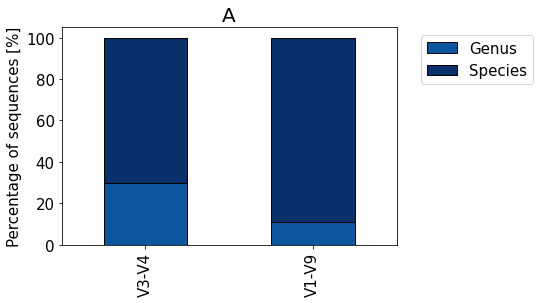

In [20]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
# Filter only levels with assignments to get the legend bar right
to_plot_all_gg = all_gg_highest_class_ratio.loc[:, all_gg_highest_class_ratio.any()]

fig, ax = plt.subplots()
to_plot_all_gg.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)
ax.set_title('A', fontsize=20)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/01_Unsimulated_reads/V1V9_V3V4_without_key.png', bbox_inches='tight')

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/2787430664.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


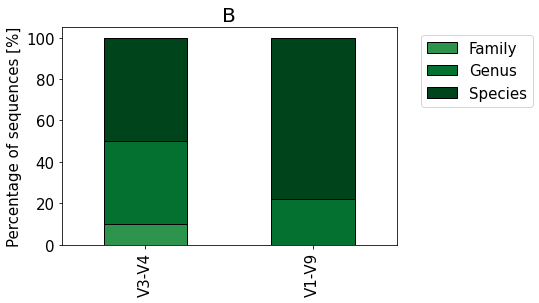

In [21]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
all_gg_correct_class_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax, legend=False, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_title('B', fontsize=20)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/01_Unsimulated_reads/V1V9_V3V4_with_key.png', bbox_inches='tight')

##### 2.1.2 Long vs short classifier

In [22]:
long_vs_short_highest_class, long_vs_short_highest_class_ratio = highest_classification([V3V4_gg_correct_seqs_short_class, V3V4_gg_correct_seqs], names=['Short', 'Full-length'])
long_vs_short_correct_class, long_vs_short_correct_class_ratio = highest_classification_with_key([V3V4_gg_correct_seqs_short_class, V3V4_gg_correct_seqs], names=['Short', 'Full-length'], taxonomy=taxonomy, conversion_dict=conversion_dict)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/963331723.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


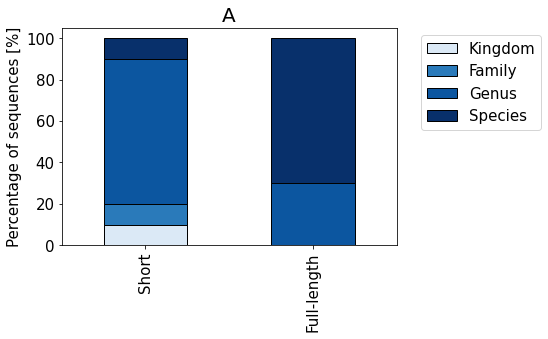

In [23]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
# Filter only levels with assignments to get the legend bar right
to_plot_long_vs_short = long_vs_short_highest_class_ratio.loc[:, long_vs_short_highest_class_ratio.any()]

fig, ax = plt.subplots()
to_plot_long_vs_short.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax, legend=False, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)
ax.set_title('A', fontsize=20)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/01_Unsimulated_reads/Long_vs_short_without_key.png', bbox_inches='tight')

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/1080359381.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


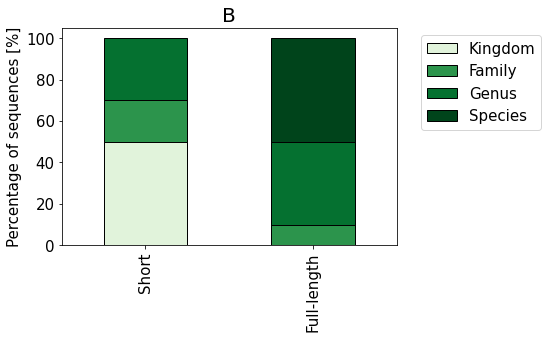

In [24]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
long_vs_short_correct_class_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax, legend=False, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_title('B', fontsize=20)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/01_Unsimulated_reads/Long_vs_short_with_key.png', bbox_inches='tight')

##### 2.2 Simulated reads

In [25]:
simulated_gg_highest_class, simulated_gg_highest_class_ratio = highest_classification([illumina_gg_correct_seqs, pacbio_gg_correct_seqs], names=['Illumina', 'PacBio'])
simulated_gg_correct_class, simulated_gg_correct_class_ratio = highest_classification_with_key([illumina_gg_correct_seqs, pacbio_gg_correct_seqs], names=['Illumina', 'PacBio'], taxonomy=taxonomy, conversion_dict=conversion_dict)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/2791571386.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


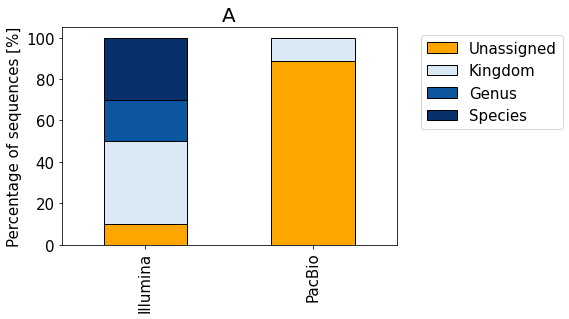

In [26]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
# Filter only levels with assignments to get the legend bar right
to_plot_all_simulated = simulated_gg_highest_class_ratio.loc[:, simulated_gg_highest_class_ratio.any()]

fig, ax = plt.subplots()
to_plot_all_simulated.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax, legend=False, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)
ax.set_title('A', fontsize=20)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/02_Simulated_reads/Simulated_without_key.png', bbox_inches='tight')

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_61111/3716500236.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)


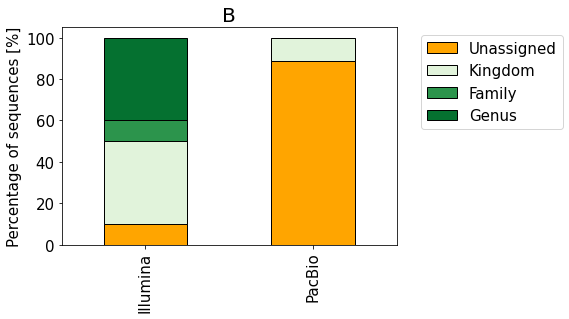

In [27]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
simulated_gg_correct_class_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax, legend=False, fontsize=15)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=15)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=15)
ax.set_title('B', fontsize=20)
ax.set_ylabel('Percentage of sequences [%]', fontsize=15)

plt.show()

fig.savefig('/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/02_Plots/02_Simulated_reads/Simulated_with_key.png', bbox_inches='tight')